# Zero Curve

## Curve definition main input 

* Currency 
* Rate index
* Tenor
* Holidays
* Interpolator
* Interpolation space
* Generation algorithm
* Day Count Convention
* Compounding frequency

## Diversity of Yield Curves

* Observed curves or market curves that are built directly from quotations on the markets (e.g. \textbf{swap curves}, \textbf{government bond yield curves})
* Implicit curves, which are derived from market quotes , but are obtained via transformation (e.g. zero-coupon yield curves, par yield curves)


## Curve Underlyings 

### Instrument types

* Money Market
* FRA
* Future
* Bond Future
* Swap
* Spread
* Turn Rate
* Bond

### Qualitative aspects about Curve Underlying Instruments 

* In order to have a consistent set of data, yield curves are always constructed using the yield rates of a set of homogeneous instruments.
* Use same quote instance (OPEN, CLOSE, LAST, BID, ASK, MID etc)
* For these securities we can calculate the zero-coupon rates directly from their market price:
* For bond yield curves
    * Uses instruments from the same issuer or, if it is a sector curve, from issuers which belong to the same sector.
    * Thus, for example, two bonds with the same maturity but a very different duration, will not have the same yield. Also, two identical coupons belonging to two bonds with different maturities will not be discounted at the same yield, whereas they generate the exact same cash flow.


## Issues

* Curve underlyings and curve set with different holidays

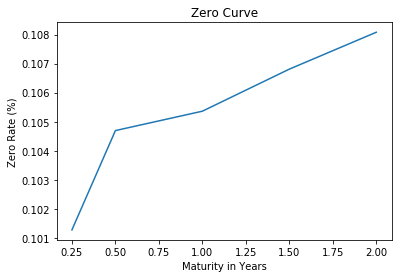

In [19]:
""" Bootstrapping the yield curve """
import math
    
class BootstrapYieldCurve(object):
    
    def __init__(self):
        self.zero_rates = dict()  # Map each T to a zero rate
        self.instruments = dict()  # Map each T to an instrument
        
    def add_instrument(self, par, T, coup, price, compounding_freq=2):
        """  Save instrument info by maturity """
        self.instruments[T] = (par, coup, price, compounding_freq)
    
    def get_zero_rates(self):
        """  Calculate a list of available zero rates """
        self.__bootstrap_zero_coupons__()
        self.__get_bond_spot_rates__()
        return [self.zero_rates[T] for T in self.get_maturities()]
        
    def get_maturities(self):
        """ Return sorted maturities from added instruments. """
        return sorted(self.instruments.keys())
        
    def __bootstrap_zero_coupons__(self):
        """ Get zero rates from zero coupon bonds """
        for T in self.instruments.keys():
            (par, coup, price, freq) = self.instruments[T]
            if coup == 0:
                self.zero_rates[T] = \
                    self.zero_coupon_spot_rate(par, price, T)
                    
    def __get_bond_spot_rates__(self):
        """ Get spot rates for every marurity available """
        for T in self.get_maturities():
            instrument = self.instruments[T]
            (par, coup, price, freq) = instrument

            if coup != 0:
                self.zero_rates[T] = \
                    self.__calculate_bond_spot_rate__(
                        T, instrument)
                
    def __calculate_bond_spot_rate__(self, T, instrument):
        """ Get spot rate of a bond by bootstrapping """
        try:
            (par, coup, price, freq) = instrument
            periods = T * freq  # Number of coupon payments
            value = price
            per_coupon = coup / freq  # Coupon per period

            for i in range(int(periods)-1):
                t = (i+1)/float(freq)
                spot_rate = self.zero_rates[t]
                discounted_coupon = per_coupon * \
                                    math.exp(-spot_rate*t)
                value -= discounted_coupon

            # Derive spot rate for a particular maturity
            last_period = int(periods)/float(freq)        
            spot_rate = -math.log(value /
                                  (par+per_coupon))/last_period
            return spot_rate

        except:
            print("Error: spot rate not found for T=%s" % t)
            
    def zero_coupon_spot_rate(self, par, price, T):
        """ Get zero rate of a zero coupon bond """
        spot_rate = math.log(par/price)/T
        return spot_rate


if __name__ == "__main__":
    yield_curve = BootstrapYieldCurve()
    yield_curve.add_instrument(100, 0.25, 0., 97.5)
    yield_curve.add_instrument(100, 0.5, 0., 94.9)
    yield_curve.add_instrument(100, 1.0, 0., 90.)
    yield_curve.add_instrument(100, 1.5, 8, 96., 2)
    yield_curve.add_instrument(100, 2., 12, 101.6, 2)
    y = yield_curve.get_zero_rates()
    x = yield_curve.get_maturities()

    import matplotlib.pyplot as plt
    plt.plot(x, y)
    plt.title("Zero Curve")
    plt.ylabel("Zero Rate (%)")
    plt.xlabel("Maturity in Years")
    plt.show()